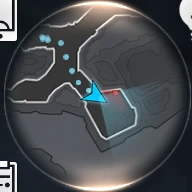

In [ ]:
import cv2
import numpy as np
from IPython.display import display
from PIL import Image
from matplotlib import pyplot as plt
from scipy import signal

img = cv2.imread('1.png')
# 在 notebook 中显示图片
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()
display(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))


In [3]:
def convolve(arr, kernel=3):
    """
    Args:
        arr (np.ndarray): Shape (N,)
        kernel (int):

    Returns:
        np.ndarray:
    """
    return sum(
        np.roll(arr, i) * (kernel - abs(i)) // kernel
        for i in range(-kernel + 1, kernel)
    )


def peak_confidence(arr, **kwargs):
    """
    Evaluate the prominence of the highest peak

    Args:
        arr (np.ndarray): Shape (N,)
        **kwargs: Additional kwargs for signal.find_peaks

    Returns:
        float: 0-1
    """
    para = {
        "height": 0,
        "prominence": 10,
    }
    para.update(kwargs)
    length = len(arr)
    peaks, properties = signal.find_peaks(np.concatenate((arr, arr, arr)), **para)
    peaks = [
        h for p, h in zip(peaks, properties["peak_heights"]) if length <= p < length * 2
    ]
    peaks = sorted(peaks, reverse=True)

    count = len(peaks)
    if count > 1:
        highest, second = peaks[0], peaks[1]
    elif count == 1:
        highest, second = 1, 0
    else:
        highest, second = 1, 0
    confidence = (highest - second) / highest
    return confidence


def RotationRemapData(d):
    mx = np.zeros((d, d), dtype=np.float32)
    my = np.zeros((d, d), dtype=np.float32)
    for i in range(d):
        for j in range(d):
            mx[i, j] = d / 2 + i / 2 * np.cos(2 * np.pi * j / d)
            my[i, j] = d / 2 + i / 2 * np.sin(2 * np.pi * j / d)
    return mx, my

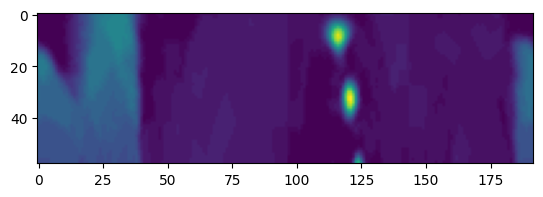

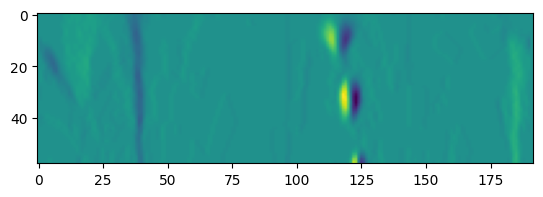

In [ ]:
d = img.shape[0]
scale = 1
_, _, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YUV))
img2 = cv2.subtract(128, v)
img2 = cv2.GaussianBlur(img2, (3, 3), 0)

remap2 = cv2.warpPolar(src = img2,
                      dst = None,
                      dsize = (d,d),
                      center = (d/2,d/2),
                      maxRadius = d/2,
                      flags = cv2.INTER_LINEAR)
remap2 = remap2.T
remap2 = remap2[d * 2 // 10 : d * 5 // 10]  # 设置了可以提高准确率，注释掉也可以运行
plt.imshow(remap2)
plt.show()

# remapData = RotationRemapData(d)
# remap = cv2.remap(img2, *remapData, cv2.INTER_LINEAR)[d * 2 // 10 : d * 5 // 10]

# plt.imshow(remap)
# plt.show()
# remap = cv2.resize(remap, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
gradx = cv2.Scharr(remap2, cv2.CV_32F, 1, 0)  # 沿x轴方向上进行Scharr
# gradx2 = cv2.Scharr(remap2, cv2.CV_32F, 1, 0)  # 沿x轴方向上进行Scharr
# ishow(remap)
plt.imshow(gradx)
plt.show()
# plt.imshow(gradx2)
# plt.show()

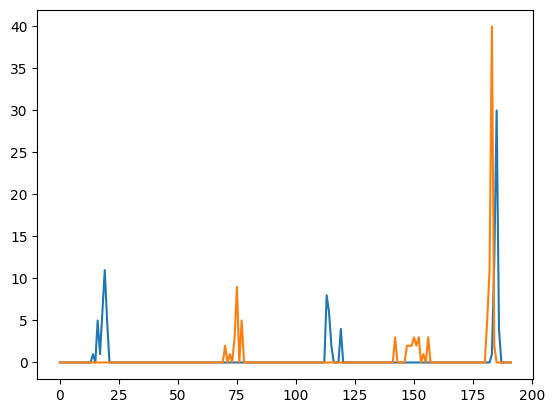

1.0


121

In [51]:
# Magic parameters for scipy.find_peaks
para = {
    "height": 50,
    "wlen": d * scale,
}
l = np.bincount(signal.find_peaks(gradx.ravel(), **para)[0] % (d * scale), minlength=d * scale)
r = np.bincount(signal.find_peaks(-gradx.ravel(), **para)[0] % (d * scale), minlength=d * scale)
l, r = np.maximum(l - r, 0), np.maximum(r - l, 0)

plt.plot(l)
plt.plot(np.roll(r, -d * scale // 4))
plt.show()
conv0 = []
kernel = 2 * scale
for offset in range(-kernel + 1, kernel):
    result = l * convolve(np.roll(r, -d * scale // 4 + offset), kernel=3 * scale)
    minus = l * convolve(np.roll(r, offset), kernel=10 * scale) // 5
    result -= minus
    result = convolve(result, kernel=3 * scale)
    conv0 += [result]
conv0 = np.array(conv0)
conv0[conv0 < 1] = 1
maximum = np.max(conv0, axis=0)
if peak_confidence(maximum) > 0.3:
    # Good match
    result = maximum
else:
    # Convolve again to reduce noice
    average = np.mean(conv0, axis=0)
    minimum = np.min(conv0, axis=0)
    result = convolve(maximum * average * minimum, 2 * scale)
# plt.plot(maximum)
# plt.plot(result)
# plt.show()

# Convert match point to degree
selfdegree = np.argmax(result) / (d * scale) * 2 * np.pi + np.pi / 4
degree = np.argmax(result) / (d * scale) * 360 + 135
degree = int(degree % 360)

# Calculate confidence
rotation_confidence = round(peak_confidence(result), 3)
print(rotation_confidence)
degree

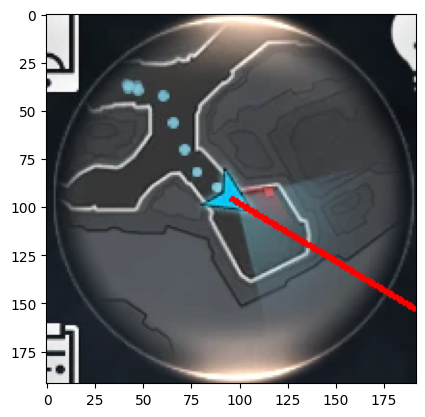

In [62]:
# 假设已有变量 img（图像）和 degree（角度，单位为度）
# 计算直线方向：degree=0 时水平向右，90 时垂直向下
angle_rad = np.deg2rad(degree-90)
h, w = img.shape[:2]
center = (w // 2, h // 2)

# 直线长度取图像对角线的一半，保证两端都在图像内
length = int(np.hypot(w, h) / 2)

# 从中心出发，只计算射线终点
dx = int(length * np.cos(angle_rad))
dy = int(length * np.sin(angle_rad))
pt2 = (center[0] + dx, center[1] + dy)
# 起点即中心
pt1 = center

# 画线：绿色，线宽 2
outimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).copy()
cv2.line(outimg, pt1, pt2, (255, 0, 0), 2)

plt.imshow(outimg)
# plt.imshow(outimg)
plt.show()